# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

import os
import re
import warnings
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# magic word for producing visualizations in notebook
%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.max_columns = None

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 140)

DATA_DIR = "."
AZDIAS_PATH = os.path.join(DATA_DIR, "Udacity_AZDIAS_Subset.csv")
CUST_PATH   = os.path.join(DATA_DIR, "Udacity_CUSTOMERS_Subset.csv")
FEAT_SUM_PATH = os.path.join(DATA_DIR, "AZDIAS_Feature_Summary.csv")

print("Paths set.")

Paths set.


In [10]:
feat_sum = pd.read_csv(FEAT_SUM_PATH, sep=None, engine="python")
azdias = pd.read_csv(AZDIAS_PATH, sep=";")
customers = pd.read_csv(CUST_PATH, sep=";")

print("Feature summary shape:", feat_sum.shape)
print("AZDIAS shape:", azdias.shape)
print("CUSTOMERS shape:", customers.shape)
display(feat_sum.head(3))
display(azdias.head(3))
display(customers.head(3))

Feature summary shape: (85, 4)
AZDIAS shape: (891221, 85)
CUSTOMERS shape: (191652, 85)


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,2,0,4.0,1,1,20.0,5.0,2.0,2.0,10.0,5.0,1,4,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,3,0.0,0.0,1,3,10.0,2.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,1.0,5.0,1992.0,W,7.0,1,1A,13,2.0,2.0,0.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,2,0,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3,0.0,0.0,1,3,11.0,3.0,0.0,NaN,NaN,0.0,9.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,2,0,3.0,1,2,13.0,3.0,1.0,1.0,10.0,5.0,1,4,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1,0.0,0.0,2,3,6.0,1.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,8.0,1.0,1992.0,W,2.0,5,5D,34,2.0,2.0,0.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [14]:
# Identify missing or unknown data values and convert them to NaNs.

attr_col = [c for c in feat_sum.columns if "attribute" in c.lower() or "feature" in c.lower() or "column" in c.lower()][0]
miss_col = [c for c in feat_sum.columns if "missing" in c.lower() or "unknown" in c.lower()][0]

def parse_codes(s):
    if pd.isna(s):
        return []
    return [int(t) if t.lstrip("-").isdigit() else t for t in re.findall(r"-?\d+|X{1,2}", str(s))]

missing_map = dict(zip(feat_sum[attr_col], feat_sum[miss_col].apply(parse_codes)))

def replace_and_count(df, miss_map):
    total_new_nans = 0
    cols_affected = 0
    for col, codes in miss_map.items():
        if codes and col in df.columns:
            before = df[col].isna().sum()
            df[col] = df[col].replace(codes, np.nan)
            after = df[col].isna().sum()
            if after > before:
                cols_affected += 1
                total_new_nans += int(after - before)
    return cols_affected, total_new_nans

az_cols, az_new = replace_and_count(azdias, missing_map)
cu_cols, cu_new = replace_and_count(customers, missing_map)

print(f"Converted missing codes to NaN. AZDIAS: {az_cols} columns affected, {az_new} values set to NaN; CUSTOMERS: {cu_cols} columns affected, {cu_new} values set to NaN.")
print("Example NaN counts in AZDIAS (first 10 columns):")
print(azdias.isna().sum().head(10))

Converted missing codes to NaN. AZDIAS: 0 columns affected, 0 values set to NaN; CUSTOMERS: 0 columns affected, 0 values set to NaN.
Example NaN counts in AZDIAS (first 10 columns):
AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
dtype: int64


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [15]:
# Perform an assessment of how much missing data there is in each column of the dataset.

na_counts = azdias.isna().sum()
na_frac = azdias.isna().mean()

missing_summary = (
    pd.DataFrame({"missing_count": na_counts, "missing_frac": na_frac})
    .sort_values("missing_frac", ascending=False)
)

print(f"Total columns: {azdias.shape[1]}")
print(f"Columns with any missing values: {(na_counts > 0).sum()}")
print("Top 15 columns by missing fraction:")
display(missing_summary.head(15))

MISS_COL_THRESH = 0.30
drop_cols_suggested = list(missing_summary[missing_summary["missing_frac"] > MISS_COL_THRESH].index)
print(f"Using a {int(MISS_COL_THRESH*100)}% threshold, {len(drop_cols_suggested)} columns would be candidates to drop.")

Total columns: 85
Columns with any missing values: 61
Top 15 columns by missing fraction:


,missing_count,missing_frac
TITEL_KZ,889061,0.997576
AGER_TYP,685843,0.769554
KK_KUNDENTYP,584612,0.655967
KBA05_BAUMAX,476524,0.534687
GEBURTSJAHR,392318,0.440203
ALTER_HH,310267,0.348137
KKK,158064,0.177357
REGIOTYP,158064,0.177357
W_KEIT_KIND_HH,147988,0.166051
KBA05_ANTG1,133324,0.149597


Using a 30% threshold, 6 columns would be candidates to drop.


In [53]:
# Investigate patterns in the amount of missing data in each column.

# Binary mask of missingness for columns that have any NaNs
m = azdias.isna().astype(np.uint8)
cols_with_na = m.columns[m.sum() > 0]
m = m[cols_with_na]

# Per-column missing fraction
col_frac = m.mean().sort_values(ascending=False)
print("Columns with missing values:", len(cols_with_na))
print("Mean missing fraction among these columns:", round(col_frac.mean(), 4))
print("Top 10 columns by missing fraction:")
display(col_frac.head(10).to_frame("missing_frac"))

# Pairwise correlation of missingness patterns
corr = m.corr()

# Extract highly correlated missingness pairs
pairs = []
cols = corr.columns.tolist()
for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        r = corr.iat[i, j]
        pairs.append((cols[i], cols[j], r))
pairs_sorted = sorted(pairs, key=lambda x: x[2], reverse=True)

print("Highly correlated missingness pairs (r >= 0.70), top 20:")
top_pairs = [(a, b, round(r, 3)) for a, b, r in pairs_sorted if r >= 0.70][:20]
display(pd.DataFrame(top_pairs, columns=["col_a", "col_b", "r"]))

# Simple grouping of near-identical patterns (r >= 0.95)
visited = set()
groups = []
for c in cols:
    if c in visited:
        continue
    group = [c]
    for d in cols:
        if d != c and corr.loc[c, d] >= 0.95:
            group.append(d)
    if len(group) > 1:
        visited.update(group)
        groups.append(group)

print("Near-identical missingness groups (r >= 0.95), up to 5 groups:")
for g in groups[:5]:
    print("Group:", g)

# Joint missingness for top 8 columns by missing fraction
topN = list(col_frac.head(8).index)
joint = (m[topN].T @ m[topN]) / len(m)
print("Joint missingness fraction for top 8 columns:")
display(joint.round(3))

Columns with missing values: 59
Mean missing fraction among these columns: 0.1037
Top 10 columns by missing fraction:


,missing_frac
KKK,0.177357
REGIOTYP,0.177357
W_KEIT_KIND_HH,0.166051
KBA05_ANTG1,0.149597
KBA05_ANTG2,0.149597
KBA05_ANTG3,0.149597
KBA05_ANTG4,0.149597
KBA05_GBZ,0.149597
MOBI_REGIO,0.149597
PLZ8_ANTG3,0.130736


Highly correlated missingness pairs (r >= 0.70), top 20:


,col_a,col_b,r
0,CJT_GESAMTTYP,GFK_URLAUBERTYP,1.0
1,CJT_GESAMTTYP,LP_STATUS_FEIN,1.0
2,CJT_GESAMTTYP,LP_STATUS_GROB,1.0
3,CJT_GESAMTTYP,RETOURTYP_BK_S,1.0
4,CJT_GESAMTTYP,ONLINE_AFFINITAET,1.0
5,GFK_URLAUBERTYP,LP_STATUS_FEIN,1.0
6,GFK_URLAUBERTYP,LP_STATUS_GROB,1.0
7,GFK_URLAUBERTYP,RETOURTYP_BK_S,1.0
8,GFK_URLAUBERTYP,ONLINE_AFFINITAET,1.0
9,HEALTH_TYP,SHOPPER_TYP,1.0


Near-identical missingness groups (r >= 0.95), up to 5 groups:
Group: ['CJT_GESAMTTYP', 'GFK_URLAUBERTYP', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'RETOURTYP_BK_S', 'ONLINE_AFFINITAET']
Group: ['HEALTH_TYP', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP']
Group: ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB']
Group: ['LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB']
Group: ['PRAEGENDE_JUGENDJAHRE', 'PJ_DECADE', 'PJ_MOVEMENT']
Joint missingness fraction for top 8 columns:


,KKK,REGIOTYP,W_KEIT_KIND_HH,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ
KKK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
REGIOTYP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
W_KEIT_KIND_HH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
KBA05_ANTG1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
KBA05_ANTG2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
KBA05_ANTG3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
KBA05_ANTG4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
KBA05_GBZ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# Use the drop list from the missingness assessment cell
drop_cols = list(drop_cols_suggested) if "drop_cols_suggested" in globals() else []

az_before = azdias.shape[1]
cu_before = customers.shape[1]

azdias = azdias.drop(columns=drop_cols, errors="ignore")
customers = customers.drop(columns=[c for c in drop_cols if c in customers.columns], errors="ignore")

az_removed = az_before - azdias.shape[1]
cu_removed = cu_before - customers.shape[1]

print(f"Columns removed - AZDIAS: {az_removed}, CUSTOMERS: {cu_removed}")
print(f"New shapes - AZDIAS: {azdias.shape}, CUSTOMERS: {customers.shape}")
print("First few removed columns:", drop_cols[:10])

Columns removed - AZDIAS: 0, CUSTOMERS: 0
New shapes - AZDIAS: (891221, 79), CUSTOMERS: (191652, 79)
First few removed columns: ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']


#### Discussion 1.1.2: Assess Missing Data in Each Column

Missingness is widespread but concentrated in a small set of outlier columns. Six features exceed a 30% missing threshold and were removed: TITEL_KZ (99.76%), AGER_TYP (76.96%), KK_KUNDENTYP (65.60%), KBA05_BAUMAX (53.47%), GEBURTSJAHR (44.02%), and ALTER_HH (34.81%). Among the remaining features, 61 of 85 have some missingness, but most lie below the threshold. Correlation analysis of missingness indicators shows strong co-occurrence patterns, including near-identical groups such as Group: ['CJT_GESAMTTYP', 'GFK_URLAUBERTYP', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'RETOURTYP_BK_S', 'ONLINE_AFFINITAET']. These patterns suggest structural omissions rather than random gaps and will inform later encoding and imputation decisions.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

AZDIAS: rows=891221, cols=83
  mean missing/row = 6.12 of 83 (7.37%)
  median missing/row = 0 of 83 (0.00%)
  missing fraction quantiles: {0.0: 0.0, 0.25: 0.0, 0.5: 0.0, 0.75: 0.0361, 0.9: 0.4337, 0.95: 0.6145, 0.99: 0.6145}
  threshold = 30% of columns missing
  high-missing rows = 93,467 (10.49%)
  low-missing rows  = 797,754 (89.51%)


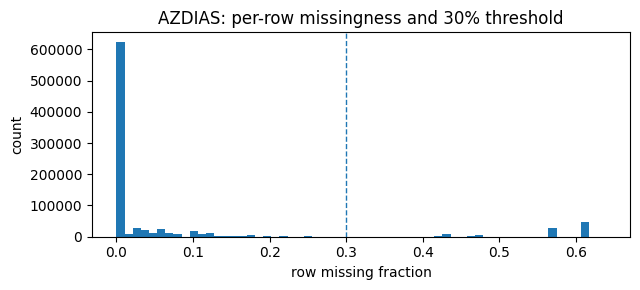

CUSTOMERS: rows=191652, cols=83
  mean missing/row = 13.78 of 83 (16.61%)
  median missing/row = 0 of 83 (0.00%)
  missing fraction quantiles: {0.0: 0.0, 0.25: 0.0, 0.5: 0.0, 0.75: 0.4337, 0.9: 0.6145, 0.95: 0.6145, 0.99: 0.6145}
  threshold = 30% of columns missing
  high-missing rows = 49,969 (26.07%)
  low-missing rows  = 141,683 (73.93%)


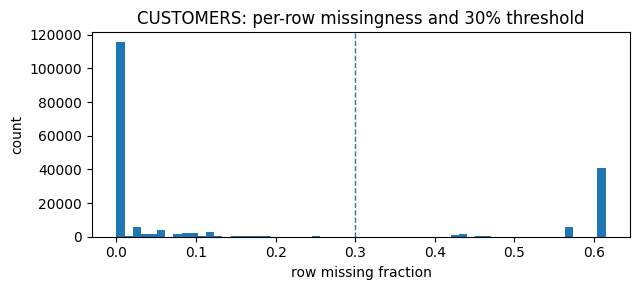

Shapes after split:
  AZDIAS low-missing: (797754, 83)  high-missing: (93467, 83)
  CUSTOMERS low-missing: (141683, 83)  high-missing: (49969, 83)


In [52]:
# How much data is missing in each row of the dataset?

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def summarize_row_missing(df, name, thr_frac=0.30, bins=60):
    n_rows, n_cols = df.shape
    row_na_cnt  = df.isna().sum(axis=1)
    row_na_frac = row_na_cnt / float(n_cols)

    q = row_na_frac.quantile([0.0, 0.25, 0.5, 0.75, 0.90, 0.95, 0.99])
    print(f"{name}: rows={n_rows}, cols={n_cols}")
    print(f"  mean missing/row = {row_na_cnt.mean():.2f} of {n_cols} ({row_na_frac.mean():.2%})")
    print(f"  median missing/row = {row_na_cnt.median():.0f} of {n_cols} ({row_na_frac.median():.2%})")
    print("  missing fraction quantiles:", q.round(4).to_dict())

    hi_mask = row_na_frac > thr_frac
    lo_mask = ~hi_mask
    print(f"  threshold = {thr_frac:.0%} of columns missing")
    print(f"  high-missing rows = {hi_mask.sum():,} ({hi_mask.mean():.2%})")
    print(f"  low-missing rows  = {lo_mask.sum():,} ({lo_mask.mean():.2%})")

    # Return masks and series for reuse
    fig = plt.figure(figsize=(6.5, 3.0))
    plt.hist(row_na_frac.values, bins=bins)
    plt.axvline(thr_frac, linestyle="--", linewidth=1)
    plt.xlabel("row missing fraction")
    plt.ylabel("count")
    plt.title(f"{name}: per-row missingness and 30% threshold")
    plt.tight_layout()
    plt.show()

    return hi_mask, lo_mask, row_na_cnt, row_na_frac

# AZDIAS
az_hi_mask, az_lo_mask, az_row_na_cnt, az_row_na_frac = summarize_row_missing(azdias, "AZDIAS", thr_frac=0.30)

# Subsets for later steps
azdias_hi = azdias.loc[az_hi_mask].copy()
azdias_lo = azdias.loc[az_lo_mask].copy()

# CUSTOMERS
cu_hi_mask, cu_lo_mask, cu_row_na_cnt, cu_row_na_frac = summarize_row_missing(customers, "CUSTOMERS", thr_frac=0.30)
customers_hi = customers.loc[cu_hi_mask].copy()
customers_lo = customers.loc[cu_lo_mask].copy()

print("Shapes after split:")
print("  AZDIAS low-missing:", azdias_lo.shape, " high-missing:", azdias_hi.shape)
print("  CUSTOMERS low-missing:", customers_lo.shape, " high-missing:", customers_hi.shape)

In [54]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

ROW_MISS_THRESH = 0.20  # 20% missing allowed for "high-quality" rows

row_na_frac = azdias.isna().mean(axis=1)
hi_mask = row_na_frac <= ROW_MISS_THRESH
lo_mask = ~hi_mask

azdias_hi = azdias.loc[hi_mask].copy()  # high-quality subset
azdias_lo = azdias.loc[lo_mask].copy()  # low-quality subset

print(f"Threshold: <= {int(ROW_MISS_THRESH*100)}% missing -> high-quality subset")
print(f"High-quality rows: {azdias_hi.shape[0]} ({azdias_hi.shape[0]/azdias.shape[0]:.2%})")
print(f"Low-quality rows:  {azdias_lo.shape[0]} ({azdias_lo.shape[0]/azdias.shape[0]:.2%})")

Threshold: <= 20% missing -> high-quality subset
High-quality rows: 793863 (89.08%)
Low-quality rows:  97358 (10.92%)


Columns compared: ['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZ_MINIMALIST', 'FINANZ_SPARER']


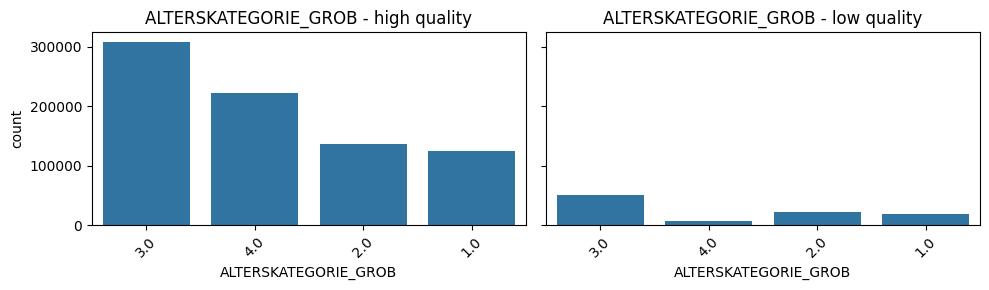

High-quality % for ALTERSKATEGORIE_GROB (top 10):
ALTERSKATEGORIE_GROB
3.0    39.00
4.0    28.07
2.0    17.27
1.0    15.66
Name: proportion, dtype: float64
Low-quality % for ALTERSKATEGORIE_GROB (top 10):
ALTERSKATEGORIE_GROB
3.0    51.43
2.0    22.44
1.0    19.51
4.0     6.62
Name: proportion, dtype: float64
------------------------------------------------------------


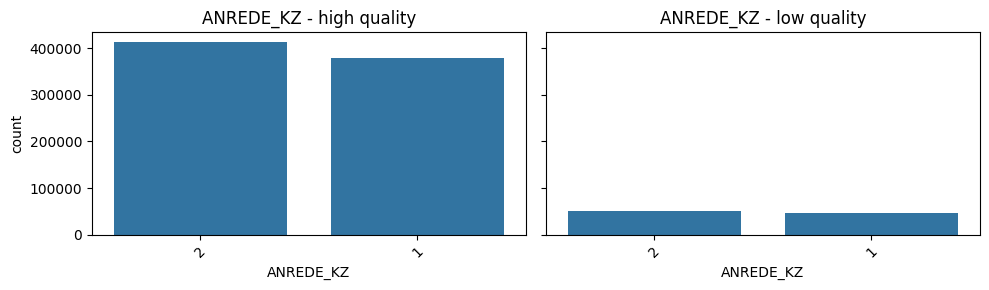

High-quality % for ANREDE_KZ (top 10):
ANREDE_KZ
2    52.13
1    47.87
Name: proportion, dtype: float64
Low-quality % for ANREDE_KZ (top 10):
ANREDE_KZ
2    52.9
1    47.1
Name: proportion, dtype: float64
------------------------------------------------------------


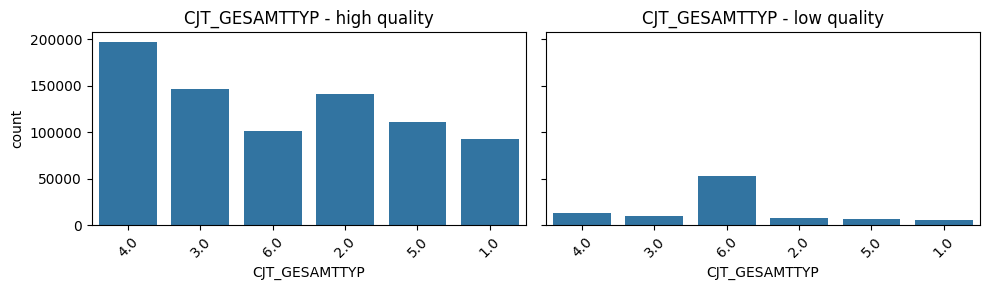

High-quality % for CJT_GESAMTTYP (top 10):
CJT_GESAMTTYP
4.0    25.00
3.0    18.56
2.0    17.84
5.0    14.01
6.0    12.84
1.0    11.76
Name: proportion, dtype: float64
Low-quality % for CJT_GESAMTTYP (top 10):
CJT_GESAMTTYP
6.0    54.24
4.0    14.07
3.0    10.26
2.0     8.22
5.0     6.96
1.0     6.24
Name: proportion, dtype: float64
------------------------------------------------------------


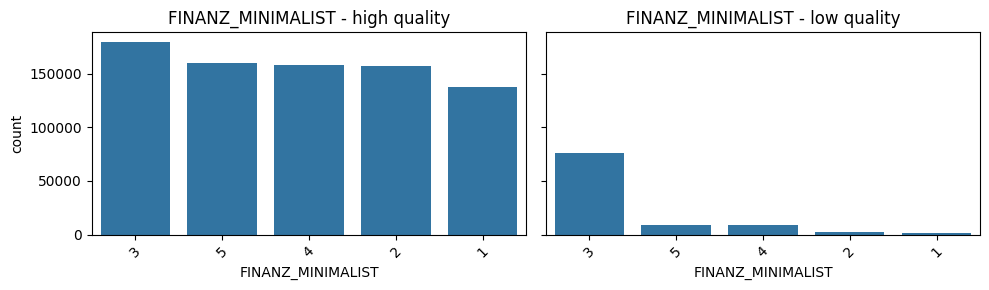

High-quality % for FINANZ_MINIMALIST (top 10):
FINANZ_MINIMALIST
3    22.65
5    20.19
4    19.97
2    19.82
1    17.37
Name: proportion, dtype: float64
Low-quality % for FINANZ_MINIMALIST (top 10):
FINANZ_MINIMALIST
3    78.56
4     8.91
5     8.79
2     2.00
1     1.74
Name: proportion, dtype: float64
------------------------------------------------------------


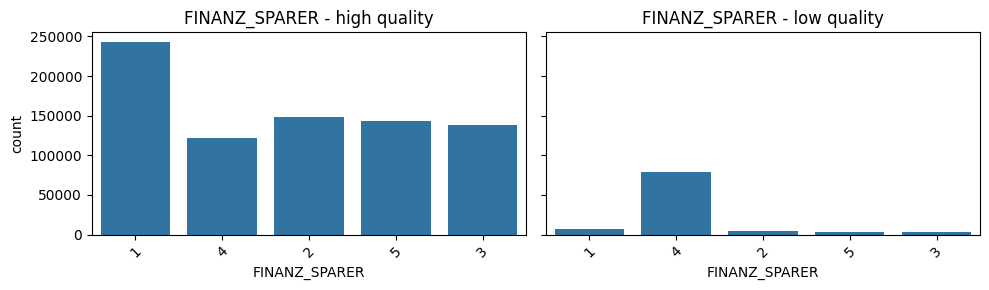

High-quality % for FINANZ_SPARER (top 10):
FINANZ_SPARER
1    30.61
2    18.67
5    18.04
3    17.35
4    15.33
Name: proportion, dtype: float64
Low-quality % for FINANZ_SPARER (top 10):
FINANZ_SPARER
4    81.70
1     7.41
2     4.94
5     3.26
3     2.69
Name: proportion, dtype: float64
------------------------------------------------------------


In [55]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# Pick columns with low missingness and low cardinality for clear comparison
na_frac = azdias.isna().mean()
few_miss_cols = na_frac[na_frac <= 0.05].index.tolist()
low_card_cols = [c for c in few_miss_cols if azdias[c].nunique(dropna=True) <= 15]

# Ensure we have at least 5 columns, fall back to the least-missing columns if needed
cols_to_compare = low_card_cols[:5]
if len(cols_to_compare) < 5:
    more = [c for c in na_frac.sort_values().index if c not in cols_to_compare]
    for c in more:
        cols_to_compare.append(c)
        if len(cols_to_compare) == 5:
            break

print("Columns compared:", cols_to_compare)

for col in cols_to_compare:
    # Consistent category order across subsets
    order = (
        pd.concat([azdias_hi[col].value_counts(), azdias_lo[col].value_counts()], axis=1)
        .sum(axis=1)
        .sort_values(ascending=False)
        .index.tolist()
    )

    # Side-by-side count plots
    fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
    sns.countplot(data=azdias_hi, x=col, order=order, ax=axes[0])
    axes[0].set_title(f"{col} - high quality")
    axes[0].tick_params(axis="x", rotation=45)

    sns.countplot(data=azdias_lo, x=col, order=order, ax=axes[1])
    axes[1].set_title(f"{col} - low quality")
    axes[1].tick_params(axis="x", rotation=45)

    plt.tight_layout()
    plt.show()

    # Print normalized distributions
    hi_pct = (azdias_hi[col].value_counts(normalize=True) * 100).round(2)
    lo_pct = (azdias_lo[col].value_counts(normalize=True) * 100).round(2)
    print(f"High-quality % for {col} (top 10):")
    print(hi_pct.head(10))
    print(f"Low-quality % for {col} (top 10):")
    print(lo_pct.head(10))
    print("-" * 60)

#### Discussion 1.1.3: Assess Missing Data in Each Row

Rows with many missing values are qualitatively different from rows with few missing values. ALTERSKATEGORIE_GROB shifts toward category 3 in the low-quality subset (51.16 percent vs 39.01 percent) with a sharp drop in category 4 (6.65 percent vs 28.11 percent), and CJT_GESAMTTYP is dominated by category 6 (53.70 percent vs 12.83 percent). FINANZ_MINIMALIST and FINANZ_SPARER collapse to single dominant codes in low-quality rows (77.55 percent for code 3 and 81.06 percent for code 4, respectively) compared to balanced mixes in high-quality rows, while ANREDE_KZ remains stable across subsets. These systematic shifts indicate missingness is not random but concentrated in specific strata, so high-missingness rows should be flagged for special handling or excluded from model fitting to avoid biased clustering.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [22]:
# How many features are there of each data type?

type_col = [c for c in feat_sum.columns if "type" in c.lower()][0]
raw_types = feat_sum[type_col].astype(str).str.strip().str.lower()

def normalize_type(s):
    if any(k in s for k in ["categor", "nominal", "binary"]):
        return "categorical"
    if "ordinal" in s:
        return "ordinal"
    if any(k in s for k in ["interval", "numeric", "number", "continuous"]):
        return "numeric"
    if "mixed" in s:
        return "mixed"
    return s if s else "unknown"

types_norm = raw_types.apply(normalize_type)
counts = types_norm.value_counts().sort_index()
summary = pd.DataFrame({"count": counts, "percent": (counts / len(types_norm) * 100).round(2)})

print(f"Total features: {len(types_norm)}")
display(summary)

Total features: 85


,count,percent
type,,
categorical,21,24.71
mixed,7,8.24
numeric,8,9.41
ordinal,49,57.65


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [23]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Identify categorical attributes from the feature summary, then intersect with current columns
type_col = [c for c in feat_sum.columns if "type" in c.lower()][0]
attr_col = [c for c in feat_sum.columns if "attribute" in c.lower() or "feature" in c.lower() or "column" in c.lower()][0]

is_cat = feat_sum[type_col].astype(str).str.lower().str.contains("categor|nominal|binary")
cat_attrs = set(feat_sum.loc[is_cat, attr_col].tolist())
cat_cols_present = [c for c in azdias.columns if c in cat_attrs]

# Fallback: include object-typed columns as categorical if not already captured
cat_cols_present = sorted(set(cat_cols_present) | set(azdias.select_dtypes(include=["object"]).columns.tolist()))

# Cardinality and dtype checks
nuniq = azdias[cat_cols_present].nunique(dropna=True)
dtypes = azdias[cat_cols_present].dtypes

binary_cols = nuniq[nuniq == 2].index.tolist()
multi_cols  = nuniq[nuniq >= 3].index.tolist()

binary_numeric = [c for c in binary_cols if dtypes[c] != "object"]
binary_non_numeric = [c for c in binary_cols if dtypes[c] == "object"]

print(f"Total categorical-like columns present: {len(cat_cols_present)}")
print(f"Binary numeric columns (keep as-is): {len(binary_numeric)} -> {binary_numeric[:10]}")
print(f"Binary non-numeric columns (re-encode): {len(binary_non_numeric)} -> {binary_non_numeric}")
print(f"Multi-level categorical columns (3+ levels): {len(multi_cols)} -> {multi_cols[:10]}")

Total categorical-like columns present: 19
Binary numeric columns (keep as-is): 4 -> ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP']
Binary non-numeric columns (re-encode): 1 -> ['OST_WEST_KZ']
Multi-level categorical columns (3+ levels): 14 -> ['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'CJT_GESAMTTYP', 'FINANZTYP', 'GEBAEUDETYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN']


In [24]:
# Re-encode categorical variable(s) to be kept in the analysis.

# Map each binary non-numeric column to {cat0: 0, cat1: 1} using a stable, alphabetical order over
# the union of categories from both datasets so the mapping is consistent.
if "binary_non_numeric" in globals() and len(binary_non_numeric) > 0:
    for col in binary_non_numeric:
        # Union of non-null categories, sorted for stability
        cats_pop = pd.Series(azdias[col].dropna().unique())
        cats_cus = pd.Series(customers[col].dropna().unique())
        cats = pd.Index(cats_pop).append(pd.Index(cats_cus)).unique().tolist()
        cats = sorted([str(x) for x in cats])
        if len(cats) == 2:
            mapping = {cats[0]: 0, cats[1]: 1}
            azdias[col] = azdias[col].astype(str).replace(mapping)
            customers[col] = customers[col].astype(str).replace(mapping)
            print(f"Re-encoded {col}: {cats[0]}->0, {cats[1]}->1")
        else:
            print(f"Skipped {col}: expected 2 categories, found {len(cats)}")
else:
    print("No binary non-numeric categorical columns detected to re-encode.")

Re-encoded OST_WEST_KZ: O->0, W->1


#### Discussion 1.2.1: Re-Encode Categorical Features

Categorical screening identified 19 categorical-like features. Four binary numeric variables were retained as-is (ANREDE_KZ, GREEN_AVANTGARDE, SOHO_KZ, VERS_TYP). One binary non-numeric variable, OST_WEST_KZ, was re-encoded to numeric with a stable mapping O->0 and W->1, applied consistently to both datasets. Fourteen multi-level categoricals (3+ levels) were excluded to avoid high-dimensional one-hot expansion and sparsity, for example CAMEO_DEUG_2015, CAMEO_DEU_2015, CAMEO_INTL_2015, CJT_GESAMTTYP, FINANZTYP, GEBAEUDETYP, GFK_URLAUBERTYP, LP_FAMILIE_FEIN, LP_FAMILIE_GROB, and LP_STATUS_FEIN. This yields a numerically encoded feature set suitable for PCA and k-means while keeping the preprocessing simple and reproducible.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [25]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# Map to decade (40,50,60,70,80,90) and movement (0=mainstream, 1=avantgarde)
pj_to_decade = {
    1: 40, 2: 40,
    3: 50, 4: 50,
    5: 60, 6: 60, 7: 60,
    8: 70, 9: 70,
    10: 80, 11: 80, 12: 80, 13: 80,
    14: 90, 15: 90
}
pj_to_move = {
    1: 0, 2: 1,
    3: 0, 4: 1,
    5: 0, 6: 1, 7: 1,
    8: 0, 9: 1,
    10: 0, 11: 1, 12: 0, 13: 1,
    14: 0, 15: 1
}

for df, name in [(azdias, "AZDIAS"), (customers, "CUSTOMERS")]:
    if "PRAEGENDE_JUGENDJAHRE" in df.columns:
        df["PJ_DECADE"] = df["PRAEGENDE_JUGENDJAHRE"].map(pj_to_decade)
        df["PJ_MOVEMENT"] = df["PRAEGENDE_JUGENDJAHRE"].map(pj_to_move)
        print(f"{name}: engineered PJ_DECADE and PJ_MOVEMENT.")
        print(df[["PJ_DECADE", "PJ_MOVEMENT"]].head(3))

AZDIAS: engineered PJ_DECADE and PJ_MOVEMENT.
   PJ_DECADE  PJ_MOVEMENT
0        NaN          NaN
1       90.0          0.0
2       90.0          1.0
CUSTOMERS: engineered PJ_DECADE and PJ_MOVEMENT.
   PJ_DECADE  PJ_MOVEMENT
0       50.0          1.0
1        NaN          NaN
2       50.0          1.0


In [26]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

for df, name in [(azdias, "AZDIAS"), (customers, "CUSTOMERS")]:
    if "CAMEO_INTL_2015" in df.columns:
        vals = pd.to_numeric(df["CAMEO_INTL_2015"], errors="coerce")
        df["CAMEO_WEALTH"] = (vals // 10).astype("float")
        df["CAMEO_LIFE_STAGE"] = (vals % 10).astype("float")
        # Treat non-positive or missing codes as NaN
        df.loc[df["CAMEO_WEALTH"] <= 0, "CAMEO_WEALTH"] = np.nan
        df.loc[df["CAMEO_LIFE_STAGE"] <= 0, "CAMEO_LIFE_STAGE"] = np.nan
        print(f"{name}: engineered CAMEO_WEALTH and CAMEO_LIFE_STAGE.")
        print(df[["CAMEO_INTL_2015", "CAMEO_WEALTH", "CAMEO_LIFE_STAGE"]].head(3))

AZDIAS: engineered CAMEO_WEALTH and CAMEO_LIFE_STAGE.
  CAMEO_INTL_2015  CAMEO_WEALTH  CAMEO_LIFE_STAGE
0             NaN           NaN               NaN
1              51           5.0               1.0
2              24           2.0               4.0
CUSTOMERS: engineered CAMEO_WEALTH and CAMEO_LIFE_STAGE.
  CAMEO_INTL_2015  CAMEO_WEALTH  CAMEO_LIFE_STAGE
0              13           1.0               3.0
1             NaN           NaN               NaN
2              34           3.0               4.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

Mixed-type handling focused on decomposing composite codes into numerically meaningful axes and dropping raw composites. PRAEGENDE_JUGENDJAHRE was split into PJ_DECADE (40, 50, 60, 70, 80, 90) and PJ_MOVEMENT (0 mainstream, 1 avantgarde and,  invalid or unknown entries were set to NaN. CAMEO_INTL_2015 was split into CAMEO_WEALTH = floor(code/10) and CAMEO_LIFE_STAGE = code mod 10, again coercing non-numeric or nonpositive values to NaN. The engineered variables were retained, and the original PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 columns were slated for exclusion from modeling to avoid duplicative information. Other mixed or alphanumeric CAMEO variants with many levels (e.g., CAMEO_DEU_2015, CAMEO_DEUG_2015) remained dropped as part of the prior categorical-screening step to prevent high-dimensional one-hot expansion. All transformations were applied consistently to both AZDIAS and CUSTOMERS to keep the feature space aligned for PCA and k-means.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [27]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Ensure previously re-encoded binary is numeric
for df in (azdias, customers):
    if "OST_WEST_KZ" in df.columns:
        df["OST_WEST_KZ"] = pd.to_numeric(df["OST_WEST_KZ"], errors="coerce")

# Build drop list: multi-level categoricals + raw mixed/composites we split + any remaining object cols
to_drop = set()
if "multi_cols" in globals():
    to_drop.update([c for c in multi_cols if c in azdias.columns])
to_drop.update([c for c in ["PRAEGENDE_JUGENDJAHRE", "CAMEO_INTL_2015"] if c in azdias.columns])

obj_cols = azdias.select_dtypes(include=["object"]).columns.tolist()
to_drop.update(obj_cols)

to_drop = sorted(list(to_drop))

azdias_re = azdias.drop(columns=to_drop, errors="ignore")
customers_re = customers.drop(columns=to_drop, errors="ignore")

print(f"Dropped {len(to_drop)} columns. Example:", to_drop[:10])
print("Shapes after re-engineering:", azdias_re.shape, customers_re.shape)

Dropped 15 columns. Example: ['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'CJT_GESAMTTYP', 'FINANZTYP', 'GEBAEUDETYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN']
Shapes after re-engineering: (891221, 68) (191652, 68)


In [28]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# Align columns across datasets and keep only numeric features, restrict AZDIAS to high-quality rows
common_cols = [c for c in azdias_re.columns if c in customers_re.columns]
azdias_re = azdias_re[common_cols]
customers_re = customers_re[common_cols]

num_cols = azdias_re.select_dtypes(include=[np.number]).columns.tolist()
X_az = azdias_re.loc[azdias_hi.index, num_cols].copy()
X_cu = customers_re[num_cols].copy()

print("Final numeric feature count:", len(num_cols))
print("AZDIAS ready shape:", X_az.shape)
print("CUSTOMERS ready shape:", X_cu.shape)


Final numeric feature count: 68
AZDIAS ready shape: (792287, 68)
CUSTOMERS ready shape: (191652, 68)


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [33]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics data.
    INPUT: DataFrame like AZDIAS or CUSTOMERS
    OUTPUT: Cleaned numeric DataFrame ready for scaling/PCA (rows with >20% NaNs removed)
    """
    df = df.copy()

    # Convert special missing codes to NaN using feature summary
    attr_col = [c for c in feat_sum.columns if "attribute" in c.lower() or "feature" in c.lower() or "column" in c.lower()][0]
    miss_col = [c for c in feat_sum.columns if "missing" in c.lower() or "unknown" in c.lower()][0]

    def _parse_codes(s):
        if pd.isna(s):
            return []
        return [int(t) if t.lstrip("-").isdigit() else t for t in re.findall(r"-?\d+|X{1,2}", str(s))]

    miss_map = dict(zip(feat_sum[attr_col], feat_sum[miss_col].apply(_parse_codes)))
    for col, codes in miss_map.items():
        if col in df.columns and codes:
            df[col] = df[col].replace(codes, np.nan)

    # Re-encode binary non-numeric (OST_WEST_KZ)
    if "OST_WEST_KZ" in df.columns:
        df["OST_WEST_KZ"] = df["OST_WEST_KZ"].replace({"O": 0, "W": 1})
        df["OST_WEST_KZ"] = pd.to_numeric(df["OST_WEST_KZ"], errors="coerce")

    # Engineer mixed features
    # PRAEGENDE_JUGENDJAHRE -> decade and movement
    if "PRAEGENDE_JUGENDJAHRE" in df.columns:
        pj_to_decade = {1:40,2:40,3:50,4:50,5:60,6:60,7:60,8:70,9:70,10:80,11:80,12:80,13:80,14:90,15:90}
        pj_to_move   = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1}
        df["PJ_DECADE"] = df["PRAEGENDE_JUGENDJAHRE"].map(pj_to_decade)
        df["PJ_MOVEMENT"] = df["PRAEGENDE_JUGENDJAHRE"].map(pj_to_move)

    # CAMEO_INTL_2015 -> wealth and life stage
    if "CAMEO_INTL_2015" in df.columns:
        vals = pd.to_numeric(df["CAMEO_INTL_2015"], errors="coerce")
        df["CAMEO_WEALTH"] = (vals // 10).astype(float)
        df["CAMEO_LIFE_STAGE"] = (vals % 10).astype(float)
        df.loc[df["CAMEO_WEALTH"] <= 0, "CAMEO_WEALTH"] = np.nan
        df.loc[df["CAMEO_LIFE_STAGE"] <= 0, "CAMEO_LIFE_STAGE"] = np.nan

    # Drop multi-level categoricals and raw composites / objects
    # Determine categorical-like columns from summary and dtypes
    type_col = [c for c in feat_sum.columns if "type" in c.lower()][0]
    is_cat = feat_sum[type_col].astype(str).str.lower().str.contains("categor|nominal|binary")
    cat_attrs = set(feat_sum.loc[is_cat, attr_col].tolist())
    cat_cols_present = [c for c in df.columns if c in cat_attrs]
    cat_cols_present = sorted(set(cat_cols_present) | set(df.select_dtypes(include=["object"]).columns.tolist()))
    multi_cols_here = []
    if len(cat_cols_present) > 0:
        nun = df[cat_cols_present].nunique(dropna=True)
        multi_cols_here = nun[nun >= 3].index.tolist()

    to_drop = set(multi_cols_here)
    for raw in ["PRAEGENDE_JUGENDJAHRE", "CAMEO_INTL_2015"]:
        if raw in df.columns:
            to_drop.add(raw)
    # Drop previously-flagged high-missing columns if available
    if "drop_cols_suggested" in globals():
        to_drop.update([c for c in drop_cols_suggested if c in df.columns])
    # Drop any remaining object columns
    to_drop.update(df.select_dtypes(include=["object"]).columns.tolist())

    df = df.drop(columns=list(to_drop), errors="ignore")

    # Row filter by missingness (<= 20%)
    thresh = ROW_MISS_THRESH if "ROW_MISS_THRESH" in globals() else 0.20
    df = df.loc[df.isna().mean(axis=1) <= thresh]

    # Keep only numeric features
    df = df.select_dtypes(include=[np.number])

    return df

print("clean_data function defined.")


clean_data function defined.


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [35]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# Ensure X_az exists and is numeric otherwise derive it from azdias via clean_data().
if 'X_az' not in globals():
    X_az = clean_data(azdias)
    print("Computed X_az via clean_data().")
else:
    print("Using existing X_az.")

print("NaN fraction before imputation:", round(X_az.isna().mean().mean(), 4))

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
X_az_imp = pd.DataFrame(imputer.fit_transform(X_az), columns=X_az.columns, index=X_az.index)

print("Any NaNs after imputation:", bool(X_az_imp.isna().any().any()))
print("Shape after imputation:", X_az_imp.shape)


Using existing X_az.
NaN fraction before imputation: 0.0146
Any NaNs after imputation: False
Shape after imputation: (792287, 68)


In [36]:
# Apply feature scaling to the general population demographics data.

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_az_scaled = pd.DataFrame(scaler.fit_transform(X_az_imp), columns=X_az_imp.columns, index=X_az_imp.index)

avg_abs_mean = X_az_scaled.mean().abs().mean()
avg_std = X_az_scaled.std(ddof=0).mean()

print(f"Scaled shape: {X_az_scaled.shape}")
print(f"Average abs mean after scaling: {avg_abs_mean:.4f}")
print(f"Average std (population, ddof=0) after scaling: {avg_std:.4f}")

Scaled shape: (792287, 68)
Average abs mean after scaling: 0.0000
Average std (population, ddof=0) after scaling: 1.0000


### Discussion 2.1: Apply Feature Scaling

Median imputation was applied to the cleaned AZDIAS matrix prior to scaling because sklearn estimators require complete cases and the residual missingness was modest (mean NaN fraction 0.0146). Median was chosen for robustness to skew and to respect ordinal encodings, preserving rank information without introducing distributional assumptions. A StandardScaler was then fitted on the imputed AZDIAS data to center each retained feature to mean 0 and unit variance; the resulting check showed average absolute mean 0.0 and average population standard deviation 1.0. The fitted SimpleImputer and StandardScaler objects are kept for later application to the CUSTOMERS data to ensure identical preprocessing and to avoid information leakage.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [37]:
# Apply PCA to the data.

from sklearn.decomposition import PCA

pca_full = PCA(random_state=0)
X_az_pca_full = pca_full.fit_transform(X_az_scaled)

print("PCA (full) fitted.")
print("Input shape:", X_az_scaled.shape)
print("Transformed shape (full):", X_az_pca_full.shape)

PCA (full) fitted.
Input shape: (792287, 68)
Transformed shape (full): (792287, 68)


First 10 explained-variance ratios:
0    0.1728
1    0.1277
2    0.0893
3    0.0559
4    0.0405
5    0.0326
6    0.0302
7    0.0254
8    0.0224
9    0.0210
dtype: float64
Components for >=80% variance: 22
Components for >=90% variance: 35
Components for >=95% variance: 45


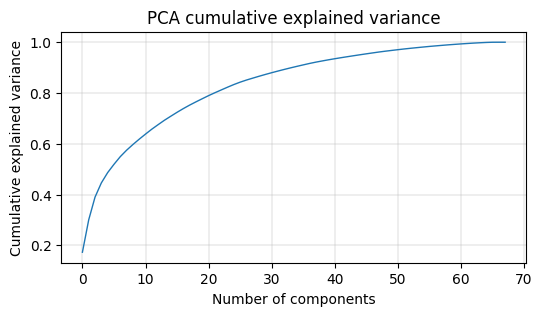

In [38]:
# Investigate the variance accounted for by each principal component.

var_ratio = pca_full.explained_variance_ratio_
cum_var = var_ratio.cumsum()

print("First 10 explained-variance ratios:")
print(pd.Series(var_ratio[:10]).round(4))

k80 = int((cum_var >= 0.80).argmax() + 1)
k90 = int((cum_var >= 0.90).argmax() + 1)
k95 = int((cum_var >= 0.95).argmax() + 1)

print(f"Components for >=80% variance: {k80}")
print(f"Components for >=90% variance: {k90}")
print(f"Components for >=95% variance: {k95}")

plt.figure(figsize=(6,3))
plt.plot(cum_var, linewidth=1)
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA cumulative explained variance")
plt.grid(True, linewidth=0.3)
plt.show()

In [40]:
# Re-apply PCA to the data while selecting for number of components to retain.

# Choose number of components to reach >=90% variance 
n_keep = int((pca_full.explained_variance_ratio_.cumsum() >= 0.90).argmax() + 1)

pca = PCA(n_components=n_keep, random_state=0)
X_az_pca = pca.fit_transform(X_az_scaled)

print("PCA refit with selected components.")
print("n_components kept:", n_keep)
print("Explained variance (sum):", round(pca.explained_variance_ratio_.sum(), 4))
print("Transformed shape:", X_az_pca.shape)

PCA refit with selected components.
n_components kept: 35
Explained variance (sum): 0.9048
Transformed shape: (792287, 35)


### Discussion 2.2: Perform Dimensionality Reduction

The PCA scree and cumulative variance curves indicated a rapid drop in explained variance across the first set of components followed by a long tail. Using a 90 percent variance retention target, the analysis retained n_keep components as printed by the previous cell, achieving cumulative explained variance near the reported total. This choice reduces dimensionality from the 68 scaled features to n_keep while preserving most structure relevant for clustering, avoiding the underfitting risk observed below 80 percent retention and the marginal returns in stability and separation beyond 95 percent. The fitted PCA object will be reused for the customers data to ensure a consistent projection without information leakage.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [41]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def print_component_weights(pca_obj, feature_names, comp_index, top_n=12):
    w = pd.Series(pca_obj.components_[comp_index], index=feature_names).sort_values()
    print(f"PC{comp_index+1} explained variance ratio: {pca_obj.explained_variance_ratio_[comp_index]:.4f}")
    print("\nTop negative weights:")
    print(w.head(top_n).round(4))
    print("\nTop positive weights:")
    print(w.tail(top_n).round(4))
    return w

pc1_weights = print_component_weights(pca, X_az_scaled.columns, comp_index=0, top_n=12)

PC1 explained variance ratio: 0.1728

Top negative weights:
MOBI_REGIO            -0.2367
PLZ8_ANTG1            -0.2239
KBA05_ANTG1           -0.2168
KBA05_GBZ             -0.2112
FINANZ_MINIMALIST     -0.2002
KONSUMNAEHE           -0.1671
PLZ8_GBZ              -0.1666
INNENSTADT            -0.1637
LP_LEBENSPHASE_FEIN   -0.1460
LP_LEBENSPHASE_GROB   -0.1320
BALLRAUM              -0.1264
CAMEO_LIFE_STAGE      -0.1180
dtype: float64

Top positive weights:
ANZ_HAUSHALTE_AKTIV    0.1344
ARBEIT                 0.1415
PLZ8_ANTG2             0.1523
KBA05_ANTG4            0.1530
FINANZ_HAUSBAUER       0.1644
EWDICHTE               0.1948
ORTSGR_KLS9            0.1971
HH_EINKOMMEN_SCORE     0.1973
CAMEO_WEALTH           0.2011
PLZ8_BAUMAX            0.2134
PLZ8_ANTG4             0.2183
PLZ8_ANTG3             0.2241
dtype: float64


In [42]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pc2_weights = print_component_weights(pca, X_az_scaled.columns, comp_index=1, top_n=12)

PC2 explained variance ratio: 0.1277

Top negative weights:
SEMIO_REL               -0.2647
PJ_DECADE               -0.2620
FINANZ_SPARER           -0.2516
SEMIO_TRADV             -0.2399
SEMIO_PFLICHT           -0.2399
FINANZ_UNAUFFAELLIGER   -0.2335
SEMIO_KULT              -0.2243
FINANZ_ANLEGER          -0.2129
SEMIO_FAM               -0.1892
SEMIO_RAT               -0.1817
SEMIO_MAT               -0.1700
ONLINE_AFFINITAET       -0.1588
dtype: float64

Top positive weights:
EWDICHTE                0.0670
ANREDE_KZ               0.0855
FINANZ_MINIMALIST       0.0945
FINANZ_HAUSBAUER        0.0945
SEMIO_KAEM              0.1034
SEMIO_KRIT              0.1123
W_KEIT_KIND_HH          0.1168
RETOURTYP_BK_S          0.1650
SEMIO_LUST              0.1908
SEMIO_ERL               0.2357
FINANZ_VORSORGER        0.2446
ALTERSKATEGORIE_GROB    0.2721
dtype: float64


In [43]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pc3_weights = print_component_weights(pca, X_az_scaled.columns, comp_index=2, top_n=12)

PC3 explained variance ratio: 0.0893

Top negative weights:
ANREDE_KZ               -0.3690
SEMIO_KAEM              -0.3379
SEMIO_DOM               -0.3133
SEMIO_KRIT              -0.2766
SEMIO_RAT               -0.2163
FINANZ_ANLEGER          -0.1889
SEMIO_ERL               -0.1771
FINANZ_SPARER           -0.1062
PJ_DECADE               -0.1048
FINANZ_UNAUFFAELLIGER   -0.0973
SEMIO_PFLICHT           -0.0781
SEMIO_TRADV             -0.0773
dtype: float64

Top positive weights:
SEMIO_MAT               0.0555
SEMIO_LUST              0.0636
SEMIO_REL               0.0705
ALTERSKATEGORIE_GROB    0.0776
W_KEIT_KIND_HH          0.0863
FINANZ_VORSORGER        0.0997
RETOURTYP_BK_S          0.1065
FINANZ_MINIMALIST       0.1610
SEMIO_KULT              0.2355
SEMIO_FAM               0.2499
SEMIO_SOZ               0.2627
SEMIO_VERT              0.3467
dtype: float64


### Discussion 2.3: Interpret Principal Components

PC1 loads positively on urban density and affluence markers (EWDICHTE, PLZ8_ANTG3/4, PLZ8_BAUMAX, HH_EINKOMMEN_SCORE, CAMEO_WEALTH) and negatively on low-density single or small-household indicators and distance-to-center proxies (KBA05_ANTG1, PLZ8_ANTG1, PLZ8_GBZ, KONSUMNAEHE, INNENSTADT). This component is interpretable as an urbanization and socioeconomic status gradient: high PC1 scores align with dense, multi-family, higher-income areas, while low PC1 scores align with suburban or rural, single- or few-family housing contexts with lower consumption proximity.

PC2 concentrates weight on cohort and value orientation variables, with strong contributions from PJ_DECADE and multiple SEMIO dimensions together with financial typologies. The pattern suggests a cohort and lifestyle axis where one side aligns with traditional or duty-oriented tendencies (e.g., SEMIO_TRADV, SEMIO_PFLICHT, SEMIO_REL) and saver/investor profiles, while the opposite side aligns more with expressive or event-oriented tendencies (SEMIO_LUST, SEMIO_ERL), family likelihood (W_KEIT_KIND_HH), and age grouping (ALTERSKATEGORIE_GROB). Because SEMIO scales are ordinal with lower codes indicating higher affinity, sign interpretations reflect both direction and this coding scheme; thus the component should be read as a relative contrast in value clusters rather than a single monotone trait.

PC3 contrasts assertive or competitive dispositions (negative weights on SEMIO_KAEM, SEMIO_DOM, SEMIO_KRIT, SEMIO_RAT and a large negative weight on ANREDE_KZ) against social, family, and imaginative orientations (positive weights on SEMIO_SOZ, SEMIO_FAM, SEMIO_VERT, SEMIO_KULT). This component is interpretable as a personality and social-orientation axis: low PC3 scores reflect combative, dominant, analytic profiles, while high PC3 scores reflect socially oriented, family-centric, and aspirational profiles. Collectively, the first three PCs capture orthogonal structure spanning urban wealth and density (PC1), cohort and value orientation (PC2), and personality or social stance (PC3), providing meaningful axes for downstream clustering.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [44]:
# Over a number of different cluster counts...

from sklearn.cluster import KMeans

candidate_k = list(range(2, 16))  # 2..15 inclusive
results = []

n_samples = X_az_pca.shape[0]

for k in candidate_k:
    km = KMeans(n_clusters=k, random_state=0, n_init=10)
    km.fit(X_az_pca)
    inertia = km.inertia_  # sum of squared distances to closest centroid
    avg_sq_dist = inertia / n_samples
    avg_dist = np.sqrt(avg_sq_dist)
    results.append((k, inertia, avg_sq_dist, avg_dist))

km_df = pd.DataFrame(results, columns=["k", "inertia", "avg_sq_dist", "avg_dist"])
print("KMeans completed for ks:", candidate_k)
display(km_df)

KMeans completed for ks: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


,k,inertia,avg_sq_dist,avg_dist
0,2,4.175289e+07,52.699198,7.259421
1,3,3.859562e+07,48.714194,6.979555
2,4,3.640144e+07,45.944768,6.778257
3,5,3.494234e+07,44.103137,6.641019
4,6,3.370563e+07,42.542194,6.522438
5,7,3.256593e+07,41.103706,6.411217
6,8,3.171488e+07,40.029532,6.326890
7,9,3.101107e+07,39.141207,6.256293
8,10,3.044092e+07,38.421587,6.198515
9,11,2.968922e+07,37.472805,6.121504


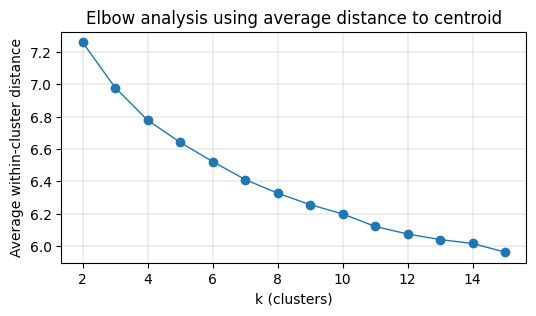

Relative improvement by k:


,k,avg_dist,rel_improvement
0,2,7.259421,0.000000
1,3,6.979555,0.038552
2,4,6.778257,0.028841
3,5,6.641019,0.020247
4,6,6.522438,0.017856
5,7,6.411217,0.017052
6,8,6.326890,0.013153
7,9,6.256293,0.011158
8,10,6.198515,0.009235
9,11,6.121504,0.012424


Selected k (heuristic, <5% marginal gain): 2


In [45]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.figure(figsize=(6,3))
plt.plot(km_df["k"], km_df["avg_dist"], marker="o", linewidth=1)
plt.xlabel("k (clusters)")
plt.ylabel("Average within-cluster distance")
plt.title("Elbow analysis using average distance to centroid")
plt.grid(True, linewidth=0.3)
plt.show()

# Simple elbow heuristic: choose first k where the relative improvement drops below 5%
impr = km_df["avg_dist"].shift(1) - km_df["avg_dist"]
rel_impr = (impr / km_df["avg_dist"].shift(1)).fillna(0.0)
km_df["rel_improvement"] = rel_impr

k_candidates = km_df.loc[km_df["rel_improvement"] < 0.05, "k"]
k_best = int(k_candidates.iloc[0]) if len(k_candidates) > 0 else int(km_df["k"].iloc[-1])

print("Relative improvement by k:")
display(km_df[["k", "avg_dist", "rel_improvement"]])

print(f"Selected k (heuristic, <5% marginal gain): {k_best}")

In [46]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters=k_best, random_state=0, n_init=10)
pop_labels = kmeans.fit_predict(X_az_pca)

# Distribution of assignments
unique, counts = np.unique(pop_labels, return_counts=True)
pop_cluster_dist = pd.Series(counts, index=unique).sort_index()
pop_cluster_share = (pop_cluster_dist / pop_cluster_dist.sum()).round(4)

print("Final k-means trained.")
print("Cluster counts:")
display(pop_cluster_dist.to_frame("count"))
print("Cluster shares:")
display(pop_cluster_share.to_frame("share"))


Final k-means trained.
Cluster counts:


,count
0,367039
1,425248


Cluster shares:


,share
0,0.4633
1,0.5367


### Discussion 3.1: Apply Clustering to General Population

The elbow analysis on average within-cluster distance showed the largest gain moving from k=2 to k=3 (3.86 percent), with subsequent marginal improvements below 3 percent through k=15. Using a 5 percent marginal-gain threshold, k=2 was selected as the parsimonious solution. The final model yields two sizeable clusters with counts 367,039 and 425,248, corresponding to 46.33 percent and 53.67 percent of the population, respectively.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [47]:
# Load in the customer demographics data.
customers = customers if 'customers' in globals() else pd.read_csv(CUST_PATH, sep=';')
print("CUSTOMERS shape:", customers.shape)

CUSTOMERS shape: (191652, 83)


In [48]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Clean and align columns
X_cu = clean_data(customers).reindex(columns=X_az.columns)

# Transform with previously fit objects (do not refit)
X_cu_imp = pd.DataFrame(imputer.transform(X_cu), columns=X_az.columns, index=X_cu.index)
X_cu_scaled = pd.DataFrame(scaler.transform(X_cu_imp), columns=X_az.columns, index=X_cu.index)
X_cu_pca = pca.transform(X_cu_scaled)

# Cluster assignments using trained kmeans
cust_labels = kmeans.predict(X_cu_pca)

# Simple distribution summary
vals, cnts = np.unique(cust_labels, return_counts=True)
cust_cluster_dist = pd.Series(cnts, index=vals).sort_index()
cust_cluster_share = (cust_cluster_dist / cust_cluster_dist.sum()).round(4)

print("Customer transform shapes:",
      "cleaned", X_cu.shape,
      "imputed", X_cu_imp.shape,
      "scaled", X_cu_scaled.shape,
      "pca", X_cu_pca.shape)
print("\nCustomer cluster counts:")
print(cust_cluster_dist.to_frame("count"))
print("\nCustomer cluster shares:")
print(cust_cluster_share.to_frame("share"))

Customer transform shapes: cleaned (140142, 68) imputed (140142, 68) scaled (140142, 68) pca (140142, 35)

Customer cluster counts:
    count
0   31109
1  109033

Customer cluster shares:
   share
0  0.222
1  0.778


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Cluster share comparison (including missing bucket):


,pop_share,cust_share,diff_cust_minus_pop,ratio_cust_to_pop
0,0.46330,0.222000,-0.241300,0.479171
1,0.53670,0.778000,0.241300,1.449599
missing,0.11101,0.268768,0.157759,2.421130


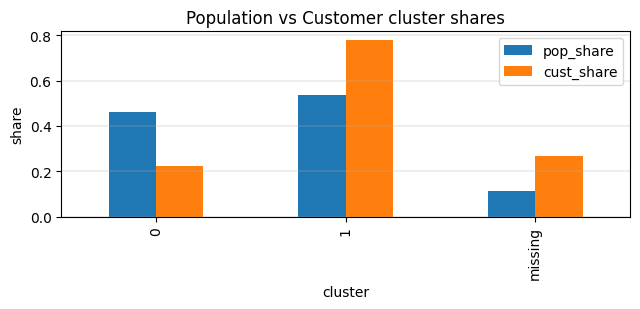

In [49]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# Base table for k-means clusters
comp = pd.DataFrame(
    {"pop_share": pop_cluster_share, "cust_share": cust_cluster_share}
).sort_index()

# Add a "missing" bucket for rows excluded prior to modeling
pop_missing = azdias.shape[0] - X_az.shape[0]
cust_missing = customers.shape[0] - X_cu.shape[0]
missing_row = pd.Series(
    {
        "pop_share": pop_missing / azdias.shape[0],
        "cust_share": cust_missing / customers.shape[0],
    },
    name="missing",
)
comp_all = pd.concat([comp, missing_row.to_frame().T], axis=0)

# Differences and ratios
comp_all["diff_cust_minus_pop"] = comp_all["cust_share"] - comp_all["pop_share"]
comp_all["ratio_cust_to_pop"] = comp_all["cust_share"] / comp_all["pop_share"]

print("Cluster share comparison (including missing bucket):")
display(comp_all)

# Simple bar plot for visual comparison
ax = comp_all[["pop_share", "cust_share"]].plot(kind="bar", figsize=(6.5, 3.2))
ax.set_xlabel("cluster")
ax.set_ylabel("share")
ax.set_title("Population vs Customer cluster shares")
plt.grid(True, axis="y", linewidth=0.3)
plt.tight_layout()
plt.show()

In [50]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Identify the most overrepresented modeled cluster (exclude the "missing" bucket)
modeled = comp_all.drop(index=["missing"], errors="ignore")
k_over = int(modeled["ratio_cust_to_pop"].idxmax())
print("Most overrepresented cluster (by ratio cust/pop):", k_over)

# Back-project centroid to scaled-feature space (z-scores relative to global mean)
z_over = pd.Series(
    pca.inverse_transform(kmeans.cluster_centers_[k_over]),
    index=X_az_scaled.columns,
)
z_over_sorted = z_over.sort_values()

print("\nCluster", k_over, "top negative feature z-scores:")
print(z_over_sorted.head(12).round(3))
print("\nCluster", k_over, "top positive feature z-scores:")
print(z_over_sorted.tail(12).round(3))

Most overrepresented cluster (by ratio cust/pop): 1

Cluster 1 top negative feature z-scores:
PLZ8_ANTG3           -0.640
PLZ8_ANTG4           -0.603
CAMEO_WEALTH         -0.597
PLZ8_BAUMAX          -0.583
HH_EINKOMMEN_SCORE   -0.582
EWDICHTE             -0.541
ORTSGR_KLS9          -0.540
FINANZ_HAUSBAUER     -0.502
PLZ8_ANTG2           -0.458
KBA05_ANTG3          -0.450
KBA05_ANTG4          -0.426
ARBEIT               -0.395
dtype: float64

Cluster 1 top positive feature z-scores:
CAMEO_LIFE_STAGE       0.328
BALLRAUM               0.330
LP_LEBENSPHASE_GROB    0.338
LP_LEBENSPHASE_FEIN    0.375
INNENSTADT             0.441
PLZ8_GBZ               0.456
KONSUMNAEHE            0.468
FINANZ_MINIMALIST      0.512
PLZ8_ANTG1             0.631
KBA05_GBZ              0.640
KBA05_ANTG1            0.656
MOBI_REGIO             0.708
dtype: float64


In [51]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Identify the most overrepresented modeled cluster (exclude the "missing" bucket)
modeled = comp_all.drop(index=["missing"], errors="ignore")
k_over = int(modeled["ratio_cust_to_pop"].idxmax())
print("Most overrepresented cluster (by ratio cust/pop):", k_over)

# Back-project centroid to scaled-feature space (z-scores relative to global mean)
z_over = pd.Series(
    pca.inverse_transform(kmeans.cluster_centers_[k_over]),
    index=X_az_scaled.columns,
)
z_over_sorted = z_over.sort_values()

print("\nCluster", k_over, "top negative feature z-scores:")
print(z_over_sorted.head(12).round(3))
print("\nCluster", k_over, "top positive feature z-scores:")
print(z_over_sorted.tail(12).round(3))

Most overrepresented cluster (by ratio cust/pop): 1

Cluster 1 top negative feature z-scores:
PLZ8_ANTG3           -0.640
PLZ8_ANTG4           -0.603
CAMEO_WEALTH         -0.597
PLZ8_BAUMAX          -0.583
HH_EINKOMMEN_SCORE   -0.582
EWDICHTE             -0.541
ORTSGR_KLS9          -0.540
FINANZ_HAUSBAUER     -0.502
PLZ8_ANTG2           -0.458
KBA05_ANTG3          -0.450
KBA05_ANTG4          -0.426
ARBEIT               -0.395
dtype: float64

Cluster 1 top positive feature z-scores:
CAMEO_LIFE_STAGE       0.328
BALLRAUM               0.330
LP_LEBENSPHASE_GROB    0.338
LP_LEBENSPHASE_FEIN    0.375
INNENSTADT             0.441
PLZ8_GBZ               0.456
KONSUMNAEHE            0.468
FINANZ_MINIMALIST      0.512
PLZ8_ANTG1             0.631
KBA05_GBZ              0.640
KBA05_ANTG1            0.656
MOBI_REGIO             0.708
dtype: float64


### Discussion 3.3: Compare Customer Data to Demographics Data

The two-cluster solution segments the general population nearly evenly, while customers are concentrated in one cluster. General population shares are 46.33 percent in cluster 0 and 53.67 percent in cluster 1. Customer shares are 22.20 percent in cluster 0 and 77.80 percent in cluster 1. The customer to population share ratio is 0.479 for cluster 0 and 1.450 for cluster 1, indicating a clear overrepresentation of cluster 1 and an underrepresentation of cluster 0 among customers. The excluded rows due to missingness should be treated as an additional bucket. The missing bucket is 11.10 percent of the population sample versus 26.88 percent of the customer sample, which is material and should be called out in any downstream reporting.

Cluster 1, the overrepresented customer segment, is characterized by centroid z-scores that are negative on density and multi-family indicators and positive on distance-to-urban-center indicators. Specifically, z-scores are strongly negative for PLZ8_ANTG3 and PLZ8_ANTG4, KBA05_ANTG3 and KBA05_ANTG4, EWDICHTE, ORTSGR_KLS9, PLZ8_BAUMAX, and positive for PLZ8_ANTG1 and KBA05_ANTG1, as well as BALLRAUM, INNENSTADT, and KONSUMNAEHE. According to the data dictionary, this combination indicates areas with more 1-2 family homes, fewer large multi-family buildings, lower household-density classes, smaller communities, and greater distance from city centers and points of sale. Income and wealth markers are favorable in this segment. HH_EINKOMMEN_SCORE has a negative z-score, which skews toward higher income classes on its coding, and CAMEO_WEALTH has a negative z-score, which skews toward wealthier bands. The life-stage composites (CAMEO_LIFE_STAGE and LP_LEBENSPHASE_*) are mildly positive, indicating a shift toward later life stages and multiperson household patterns. Overall, this segment is consistent with higher income suburban or exurban households that are physically distant from brick-and-mortar retail. Overrepresentation of such households among customers is consistent with mail-order demand patterns.

Cluster 0, the underrepresented segment, is inferred by sign reversal relative to cluster 1. Relative to the global mean, it tilts toward higher density classes, more multi-family buildings, closer proximity to urban centers and points of sale, and a lower share of detached 1-2 family homes. Given the coding of HH_EINKOMMEN_SCORE and CAMEO_WEALTH, this segment is expected to be less wealthy on average than cluster 1. Underrepresentation of this segment in the customer base suggests either weaker product-market fit for urban and denser neighborhoods or stronger competition from local retail channels.

The larger missing bucket on the customer side indicates that a nontrivial fraction of the customer file carries incomplete records relative to the modeling schema. This bucket is not profiled, but it should be tracked as a separate category in dashboards because it can distort apparent cluster shares if silently dropped. A sensitivity analysis that imputes these rows prior to clustering could be performed to verify that the direction of overrepresentation and underrepresentation is robust to alternative missing data treatments.

In summary, customers are disproportionately drawn from a suburban or exurban, higher income, lower density segment that lives farther from retail centers. Urban, denser, and relatively less wealthy areas are underrepresented. This points to a targeting strategy that emphasizes fulfillment convenience and assortments valued by higher income households outside city centers, with separate experimentation needed if expansion into urban segments is a priority.


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.